# 處理不平衡資料(imbalanced data)的一般訓練方法

我們以kaggle-信用詐欺偵測為範例介紹，一般在處理資料類別(正例/負例樣本)高度不平衡的資料集如何訓練模型.

資料來源: [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) 
合計 284,807筆交易記錄(transactions)，其中有 492 異常交易(fraudulent transactions).

**這個範例的異常交易是登記為正例樣本(positive samples)**

程式內容包括:

* 載入資料集 (CSV file).
* 建立訓練集及測試集..等資料.
* 訓練baseline模型 (使用keras).
* 評估模型績效 (precision and recall).
* 一般處理 imbalanced data 的訓練手法:
    * Class weighting
    * Oversampling


## 載入工具

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] #繪圖用的顏色

## 資料處理及資料探索(EDA)

In [4]:
tf.__version__

'2.4.1'

In [5]:
file = tf.keras.utils
#從google AIP data下載 CSV檔案資料
raw_df = pd.read_csv('datasets/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V6,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,25691.160000,1.000000


### 瞭解標記的類別資料不平衡狀況 (class label imbalance)

In [7]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



### 資料清理
1.時間(`Time`): 這一欄位我們目前沒用到,故先去除.

2.數量(`Amount`): 這個欄位資料級距差異太大,取log讓它比較趨於線性可比較.

In [8]:
cleaned_df = raw_df.copy()

# 利用pop指令移除"Time"欄位
cleaned_df.pop('Time')

# "Amount"做log轉換, 轉換時加一個很小的數值,以免轉到 np.log(0) = -inf
eps = 0.0001
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

### 切分資料集: 訓練集(train) 測試集(test) 驗證集(val, from training set)

In [9]:
# 使用 sklearn API來切分資料集.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# 整理 label資料.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [10]:
print("訓練集中的正例樣本(class=1)數量: ",len(bool_train_labels[bool_train_labels == True]))

訓練集中的正例樣本(class=1)數量:  326


### 正規化
利用sklearn StandardScaler (mean=0, standard deviation=1)
把資料集的特徵值域用標準差做縮放.

(並利用np.clip裁切值域範例在-5 ~ +5之間)

In [11]:
np.clip(-15,-5,5), np.clip(99,-5,5)

(-5, 5)

In [12]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

#把值域裁切在 -5 ~ 5之間:
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


### 觀查資料分佈狀況

比較兩組欄位資料的數值分佈狀況. **Positive (fraudulent transactions) vs. Negative (normal transactions)**

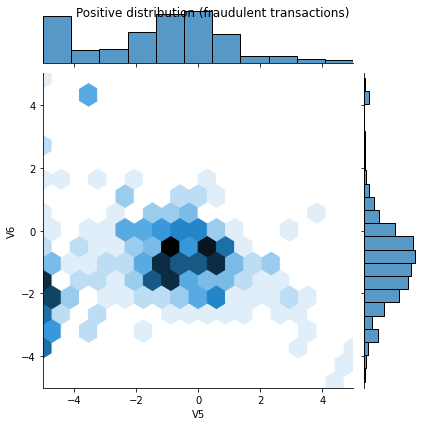

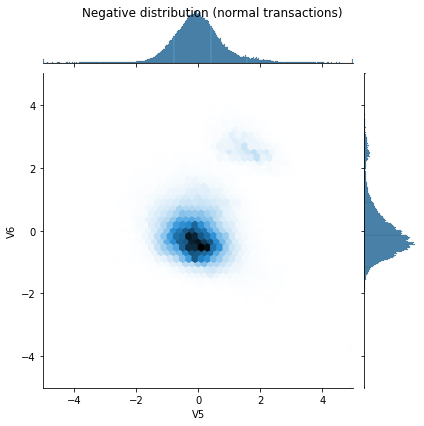

In [13]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution (fraudulent transactions)")

sns.jointplot(neg_df['V5'], neg_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution (normal transactions)")

## 定義模型結構及使用的評估指標

In [14]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [15]:
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = keras.Sequential([
              keras.layers.Dense(64, activation='relu',input_shape=(train_features.shape[-1],)),
              keras.layers.Dropout(0.5),
              keras.layers.Dense(32, activation='relu'),
              keras.layers.Dropout(0.5),
              keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
            ])
    return model

### 評估指標 (metrics)
指標公式介紹:
https://stanford.edu/~shervine/l/zh-tw/teaching/cs-229/cheatsheet-machine-learning-tips-and-tricks
*   **positives** - 正例樣本
*   **negatives** - 負例樣本
*   predict **False** - 預測錯誤(**incorrectly** classified)
*   predict **True** - 預測正確(**correctly** classified)
*   準確度(**Accuracy**) - 在所有預測樣本中，預測正確的比率
>   $\frac{\text{true samples}}{\text{total samples}}$
*   精密度(**Precision**) - 所有正例樣本中，預測正確的比率
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   召回率(**Recall**) - 所有預測樣本中，判別正例樣本且預測正確的比率
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** - Receiver Operating Characteristic curve (ROC)曲線所覆蓋的面積，數值愈接近1愈好.

Note: 在資料類別不平衡的任務，準確度(Accuracy)不是一個好的衡量指標，你可能在模型準確率99.8%+ accuracy 的狀況下，預測不出正確的分類結果。  


----

## 建立及訓練 Baseline model

In [16]:
model = make_model()
model.compile( optimizer=keras.optimizers.Adam(lr=0.001),
               loss=keras.losses.BinaryCrossentropy(),
               metrics=METRICS)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1920      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,033
Trainable params: 4,033
Non-trainable params: 0
_________________________________________________________________


In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [18]:
EPOCHS = 100
BATCH_SIZE = 1024
history = model.fit(train_df, train_labels,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1,
              shuffle=True,
              validation_split=0.2, callbacks=[early_stopping]) # 加上callbacks:earlystopping

Epoch 1/100
143/143 [==============================] - 4s 16ms/step - loss: 0.5349 - accuracy: 0.6721 - precision: 9.1146e-04 - recall: 0.1669 - auc: 0.3585 - val_loss: 0.0069 - val_accuracy: 0.9987 - val_precision: 1.0000 - val_recall: 0.0400 - val_auc: 0.8756
Epoch 2/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0192 - accuracy: 0.9978 - precision: 0.3363 - recall: 0.1569 - auc: 0.7959 - val_loss: 0.0046 - val_accuracy: 0.9992 - val_precision: 0.7750 - val_recall: 0.6200 - val_auc: 0.8996
Epoch 3/100
143/143 [==============================] - 1s 8ms/step - loss: 0.0108 - accuracy: 0.9986 - precision: 0.7490 - recall: 0.4748 - auc: 0.8804 - val_loss: 0.0039 - val_accuracy: 0.9994 - val_precision: 0.8043 - val_recall: 0.7400 - val_auc: 0.8998
Epoch 4/100
143/143 [==============================] - 1s 7ms/step - loss: 0.0076 - accuracy: 0.9991 - precision: 0.8093 - recall: 0.6270 - auc: 0.9029 - val_loss: 0.0034 - val_accuracy: 0.9995 - val_precision: 0.8125 - val_

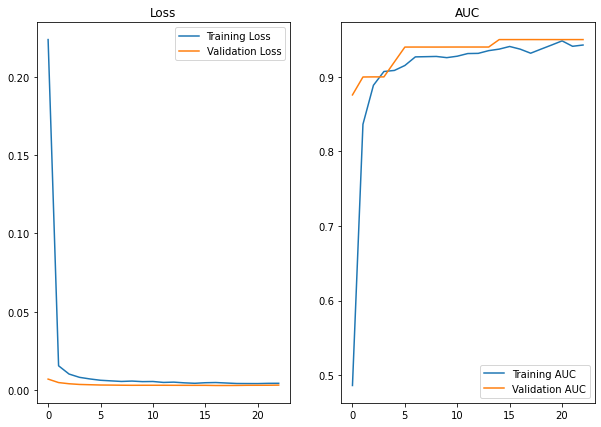

In [19]:
''' Visualize the training/validation loss and training/validation accuracy'''
plt.rcParams['figure.figsize'] = 10, 7

loss = history.history.get('loss')       # 取出訓練完成後loss的訓練數據
val_loss = history.history.get('val_loss')   # 取出訓練完成後val_loss的訓練數據
auc = history.history.get('auc')
val_auc = history.history.get('val_auc')

plt.figure(0)
plt.subplot(121)

# 個別繪出loss以及val_loss的線條
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(122)
# 個別繪出auc以及val_auc的線條
plt.plot(range(len(auc)), auc, label='Training AUC')
plt.plot(range(len(val_auc)), val_auc, label='Validation AUC')
plt.legend(loc='best')
plt.title('AUC')

plt.show()

In [20]:
pred = model.evaluate(val_df, val_labels, verbose=2)

1425/1425 - 6s - loss: 0.0035 - accuracy: 0.9993 - precision: 0.7895 - recall: 0.7792 - auc: 0.9283


In [21]:
model.predict_classes(test_features[0:1])[0], model.predict(test_features[0:1])[0]

(array([0]), array([4.090262e-12], dtype=float32))

### 儲存 initial weights (baseline model)

In [22]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [23]:
initial_weights

'C:\\Users\\user\\AppData\\Local\\Temp\\tmpfwru3hax\\initial_weights'

In [24]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])

    plt.legend()

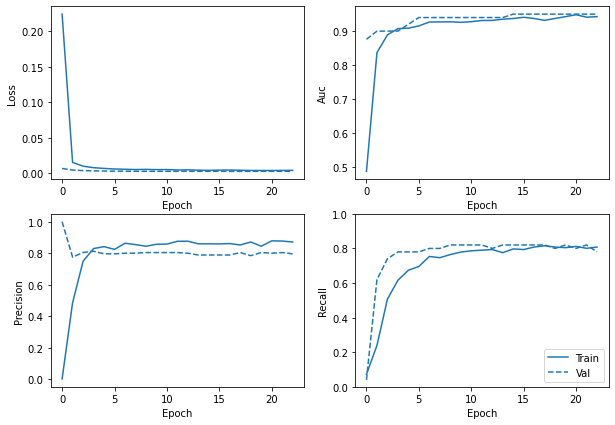

In [25]:
#儲存的第一版 base model的訓練狀況
plot_metrics(history)

### 評估指標(metrics)

In [26]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [27]:
#使用 sciki-learn API的分類報告
test_pred = model.predict_classes(test_features, batch_size=BATCH_SIZE)
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56873
           1       0.82      0.73      0.77        89

    accuracy                           1.00     56962
   macro avg       0.91      0.87      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [28]:
#混淆矩陣作成圖形顯示
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

### 利用 `model.Evaluate` 方法，計算模型績效

loss :  0.003348003840073943
accuracy :  0.9993329048156738
precision :  0.8227847814559937
recall :  0.7303370833396912
auc :  0.9482651948928833

Legitimate Transactions Detected (True Negatives):  56859
Legitimate Transactions Incorrectly Detected (False Positives):  14
Fraudulent Transactions Missed (False Negatives):  24
Fraudulent Transactions Detected (True Positives):  65
Total Fraudulent Transactions:  89


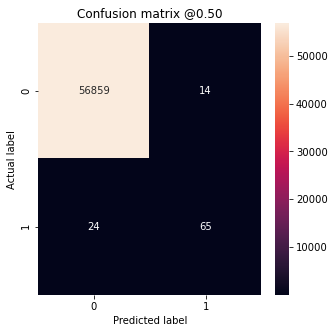

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

### 繪制ROC圖表

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

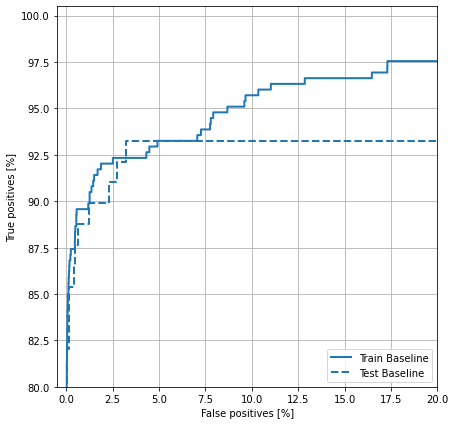

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

----

## 一般處理 imbalanced data 的訓練手法

### 類別權重 (Class weights)

### 設算類別權重

我們需合理設算樣本數少的類別在模型訓練時要加重它的權重，讓模型呈現上能有更好表現(好的績效指標).

In [32]:
print("目前資料類別的筆數狀況: 負例樣本(class-0): {} 筆, 正例樣本(class-1): {} 筆".format(neg, pos))

目前資料類別的筆數狀況: 負例樣本(class-0): 284315 筆, 正例樣本(class-1): 492 筆


In [33]:
# 基本分兩類時，我們期忘樣本比例為 total/2 ，各取一半
# 再依各類別資料比數(倒數)做加權, 讓筆數多的資料權重較少, 筆數少的資料權重較大
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('class 0 (negative)權重比率: {:.2f}'.format(weight_for_0))
print('class 1 (positive)權重比率: {:.2f}'.format(weight_for_1))

class 0 (negative)權重比率: 0.50
class 1 (positive)權重比率: 289.44


### Train a model with class weights

我們利用 `model.fit()` 參數: `class_weight` 來設定這次模型訓練的類別權重

**class_weight**
```
Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
```

In [34]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_model.compile( optimizer=keras.optimizers.Adam(lr=0.001),
               loss=keras.losses.BinaryCrossentropy(),
               metrics=METRICS)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    #設定 class weights 參數:
    class_weight=class_weight)

Epoch 1/100
179/179 [==============================] - 3s 10ms/step - loss: 0.3619 - accuracy: 0.9789 - precision: 0.1857 - recall: 0.8064 - auc: 0.9499 - val_loss: 0.0603 - val_accuracy: 0.9829 - val_precision: 0.0831 - val_recall: 0.9091 - val_auc: 0.9915
Epoch 2/100
179/179 [==============================] - 2s 9ms/step - loss: 0.2304 - accuracy: 0.9424 - precision: 0.0278 - recall: 0.8950 - auc: 0.9726 - val_loss: 0.0740 - val_accuracy: 0.9775 - val_precision: 0.0652 - val_recall: 0.9221 - val_auc: 0.9926
Epoch 3/100
179/179 [==============================] - 1s 8ms/step - loss: 0.1874 - accuracy: 0.9501 - precision: 0.0308 - recall: 0.9279 - auc: 0.9773 - val_loss: 0.0600 - val_accuracy: 0.9826 - val_precision: 0.0828 - val_recall: 0.9221 - val_auc: 0.9914
Epoch 4/100
179/179 [==============================] - 1s 8ms/step - loss: 0.1285 - accuracy: 0.9633 - precision: 0.0454 - recall: 0.9441 - auc: 0.9908 - val_loss: 0.0750 - val_accuracy: 0.9774 - val_precision: 0.0656 - val_reca

### 模型訓練狀況

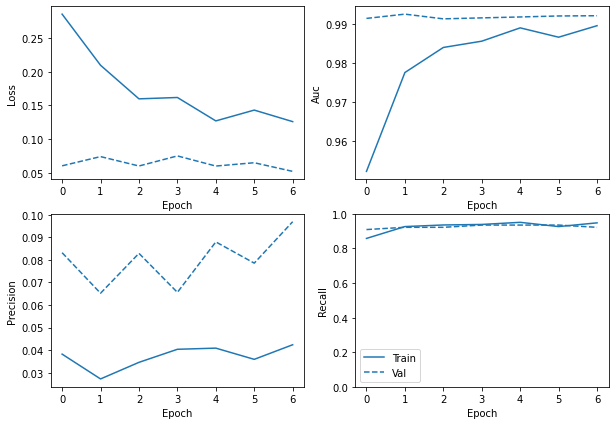

In [35]:
plot_metrics(weighted_history)

### 評估指標

In [36]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

In [37]:
test_pred = weighted_model.predict_classes(test_features, batch_size=BATCH_SIZE)
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56873
           1       0.06      0.91      0.12        89

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



loss :  0.07168443500995636
accuracy :  0.978705108165741
precision :  0.06298600137233734
recall :  0.9101123809814453
auc :  0.9770033359527588

Legitimate Transactions Detected (True Negatives):  55668
Legitimate Transactions Incorrectly Detected (False Positives):  1205
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  81
Total Fraudulent Transactions:  89


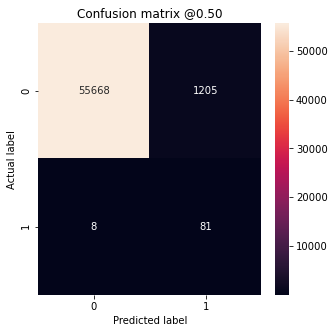

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

### 繪制ROC圖表

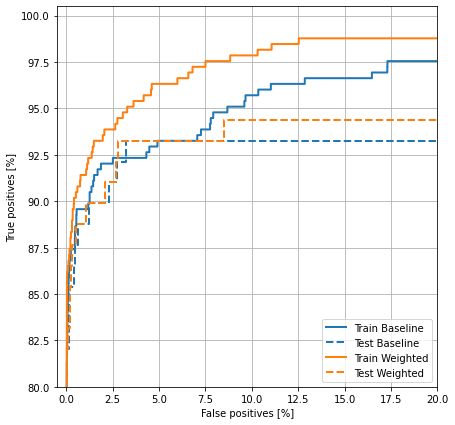

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

----

## Oversampling

利用重新抽樣，增加抽樣那些樣比數較少的類別.

In [40]:
print("(training set總筆數, train-正例樣本數, train-負例樣本數 )")
len(bool_train_labels), len(bool_train_labels[bool_train_labels == True]), len(bool_train_labels[bool_train_labels == False])

(training set總筆數, train-正例樣本數, train-負例樣本數 )


(182276, 326, 181950)

In [41]:
#從training set中分出正例及負例樣本數, 及其label資料
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### 正例樣本 oversampling
從正例樣本(訓練)資料集，oversampling 跟負例樣本(訓練)資料集相同的筆數. 

#### 方法一: 使用 `np.random.choice` (*這方法不確保訓練過程也能均勻取樣)

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181950, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

print("oversampling後的訓練資料集之筆數及欄位數目:")
resampled_features.shape

oversampling後的訓練資料集之筆數及欄位數目:


(363900, 29)

#### 方法二: 使用 `tf.data` 工具 (可以做到訓練過程也保持均勻取樣)

使用`tf.data`工具的重覆取樣(`repeat`)功能來進行oversampling.

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat() #在buffer size大小的樣本中重覆取樣
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [45]:
type(pos_ds)

tensorflow.python.data.ops.dataset_ops.RepeatDataset

RepeatDataset 可利用take()來取出(feature, label)成對的資料

In [46]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [-5.          4.63942003 -5.          3.03652596 -5.         -2.60029406
 -5.          5.         -2.14393905 -5.          2.53467509 -5.
 -0.47056511 -5.          0.99067834 -4.52863474 -5.         -3.00250561
  0.63031014  1.09010201  1.26926872 -1.28219076 -0.38015187 -0.04973758
  1.13045459 -0.54665506  2.74154593  0.67037896  0.79727639]

Label:  1


使用`experimental.sample_from_datasets`來合併 pos_ds 及 neg_ds，同時指定它們的合併比例(參數: weights)

In [47]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [48]:
for features, label in resampled_ds.take(1):
    print("BATCH_SIZE:", BATCH_SIZE)
    print("Features shape:", features.shape)
    print("Label shape: ", label.shape)
    print("each BATCH neg vs. pos 大約的數量:",(len(label[label==0]),len(label[label==1])))

BATCH_SIZE: 1024
Features shape: (1024, 29)
Label shape:  (1024,)
each BATCH neg vs. pos 大約的數量: (525, 499)


需事先設算稍後訓練過程每一個epoch要分幾個step來更新模型(每個step使用BATCH_SIZE的取樣數量)

In [49]:
(neg, pos)

(284315, 492)

In [50]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE) #因為neg vs. pos大約是各半, 故以 2倍neg的樣本數來大略估算
resampled_steps_per_epoch

556.0

### 使用oversampled data來訓練 (且每一batch取樣大略都均勻取樣)

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

resampled_model.compile( optimizer=keras.optimizers.Adam(lr=0.001),
               loss=keras.losses.BinaryCrossentropy(),
               metrics=METRICS)

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
556/556 [==============================] - 6s 9ms/step - loss: 0.1271 - accuracy: 0.9702 - precision: 0.9479 - recall: 0.9575 - auc: 0.9904 - val_loss: 0.0164 - val_accuracy: 0.9950 - val_precision: 0.2297 - val_recall: 0.8442 - val_auc: 0.9582
Epoch 2/100
556/556 [==============================] - 5s 9ms/step - loss: 0.0192 - accuracy: 0.9956 - precision: 0.9922 - recall: 0.9990 - auc: 0.9996 - val_loss: 0.0113 - val_accuracy: 0.9975 - val_precision: 0.3832 - val_recall: 0.8312 - val_auc: 0.9468
Epoch 3/100
556/556 [==============================] - 5s 9ms/step - loss: 0.0108 - accuracy: 0.9978 - precision: 0.9959 - recall: 0.9998 - auc: 0.9997 - val_loss: 0.0105 - val_accuracy: 0.9984 - val_precision: 0.5122 - val_recall: 0.8182 - val_auc: 0.9343
Epoch 4/100
556/556 [==============================] - 7s 12ms/step - loss: 0.0080 - accuracy: 0.9986 - precision: 0.9973 - recall: 0.9999 - auc: 0.9997 - val_loss: 0.0108 - val_accuracy: 0.9987 - val_precision: 0.5727 - val_reca

### 模型訓練狀況

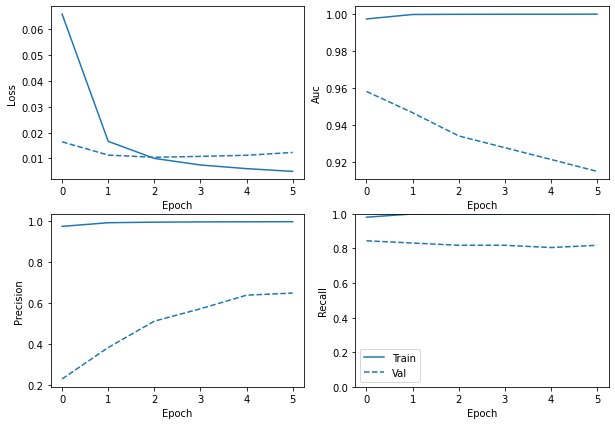

In [52]:
plot_metrics(resampled_history)

### 評估指標

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

In [54]:
test_pred = resampled_model.predict_classes(test_features, batch_size=BATCH_SIZE)
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56873
           1       0.24      0.89      0.38        89

    accuracy                           1.00     56962
   macro avg       0.62      0.94      0.69     56962
weighted avg       1.00      1.00      1.00     56962



loss :  0.015129740349948406
accuracy :  0.9954180121421814
precision :  0.2393939346075058
recall :  0.8876404762268066
auc :  0.9525514841079712

Legitimate Transactions Detected (True Negatives):  56622
Legitimate Transactions Incorrectly Detected (False Positives):  251
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  79
Total Fraudulent Transactions:  89


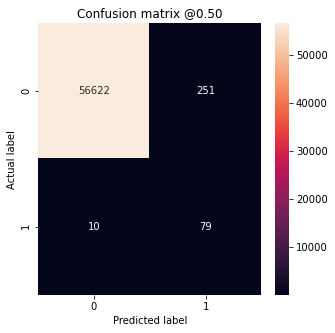

In [55]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### 繪制ROC圖表

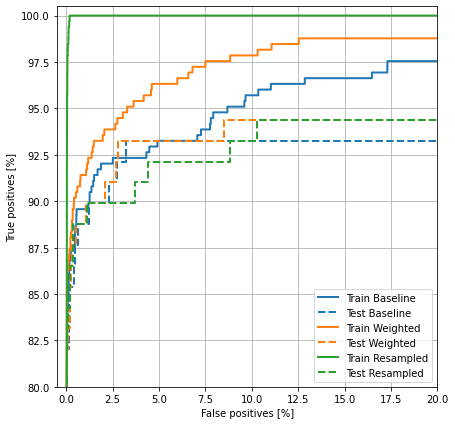

In [56]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

----